In [1]:
import os
import numpy as np
import pandas as pd
os.environ['NIXTLA_ID_AS_COL'] = '1'
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.utils import AirPassengersDF
from statsforecast.models import AutoETS
from statsforecast.utils import AirPassengers as ap
from statsforecast.models import (
    AutoARIMA, 
    SeasonalNaive,
    AutoETS,
    AutoCES,
    AutoTheta,
    ADIDA,
    CrostonClassic, 
    IMAPA, 
    TSB,
    GARCH,
    ARCH
)
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate

c:\Python\Lib\site-packages\statsforecast\core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
import sqlite3

# Conectar a la base de datos SQLite
conexion = sqlite3.connect('C:\\Users\\uriel.lezama\\Desktop\\Nuevo SAEPyTEE\\datosSINE.db')

# Definir la consulta SQL
consulta = "SELECT Fecha , [ConsumoCBO(M3)] FROM datosSINE WHERE Central='C T Punta Prieta' ORDER BY Fecha ASC "

# Ejecutar la consulta y cargar los resultados en un DataFrame
df = pd.read_sql_query(consulta, conexion)

# Cerrar la conexión a la base de datos
conexion.close()

In [3]:
columna = 'ConsumoCBO(M3)'

df[columna] = pd.to_numeric(df[columna], errors='coerce')

# Añadir una columna 'unique_id'
df['unique_id'] = range(1, len(df) + 1)
df['unique_id'] = df['unique_id'].astype(float)

# Convertir la columna 'Fecha' a formato de fecha
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Renombrar las columnas
df.rename(columns={'Fecha': 'ds', columna: 'y'}, inplace=True)
df['unique_id'] = 1.0

# Imprimir la estructura del DataFrame
df = df[['unique_id', 'ds', 'y']]

In [4]:
df

,unique_id,ds,y
0,1.0,2013-01-01,224.114
1,1.0,2013-01-02,248.818
2,1.0,2013-01-03,254.357
3,1.0,2013-01-04,243.624
4,1.0,2013-01-05,236.910
...,...,...,...
2186,1.0,2018-12-27,354.153
2187,1.0,2018-12-28,361.915
2188,1.0,2018-12-29,351.875
2189,1.0,2018-12-30,372.923


In [5]:
# Paso 1: Crear un DataFrame con todas las fechas
fechas_completas = pd.date_range(start=df['ds'].min(), end=df['ds'].max(), freq='D')

# Convertir fechas_completas a DataFrame
df_fechas_completas = pd.DataFrame({'ds': fechas_completas})

# Paso 2: Fusionar con el DataFrame original
df = pd.merge(df_fechas_completas, df, on='ds', how='outer')

# Paso 3: Rellenar valores faltantes de 'y' con ceros
df['y'] = df['y'].fillna(0)

In [6]:
df

,ds,unique_id,y
0,2013-01-01,1.0,224.114
1,2013-01-02,1.0,248.818
2,2013-01-03,1.0,254.357
3,2013-01-04,1.0,243.624
4,2013-01-05,1.0,236.910
...,...,...,...
2186,2018-12-27,1.0,354.153
2187,2018-12-28,1.0,361.915
2188,2018-12-29,1.0,351.875
2189,2018-12-30,1.0,372.923


In [7]:
# print(df.info())
# print(df)

# Supongamos que tu DataFrame se llama df y que la columna 'ds' ya es de tipo datetime
# df['ds'] = pd.to_datetime(df['ds'])

# Agrupar por semana y sumar los datos
df_por_semana = df.groupby(pd.Grouper(key='ds', freq='W')).sum()

# Asegurarse de que haya una fila para cada semana
df_por_semana = df_por_semana.asfreq('W')

# Reiniciar el índice para que vaya de 0 a n
df_por_semana = df_por_semana.reset_index()

# Rellenar valores nulos en caso de que no haya datos para alguna semana
df_por_semana = df_por_semana.fillna(0)

# Mostrar el DataFrame resultante
print(df_por_semana)

df = df_por_semana

df['unique_id'] = 1.0

            ds  unique_id         y
0   2013-01-06        6.0  1439.703
1   2013-01-13        7.0  1686.129
2   2013-01-20        7.0  1848.351
3   2013-01-27        7.0  2362.213
4   2013-02-03        7.0  2811.493
..         ...        ...       ...
309 2018-12-09        7.0  3333.411
310 2018-12-16        7.0  2607.650
311 2018-12-23        7.0  2401.115
312 2018-12-30        7.0  2415.317
313 2019-01-06        1.0   357.431

[314 rows x 3 columns]


In [8]:
ultimos_registros = df.tail()
ultimos_registros

,ds,unique_id,y
309,2018-12-09,1.0,3333.411
310,2018-12-16,1.0,2607.650
311,2018-12-23,1.0,2401.115
312,2018-12-30,1.0,2415.317
313,2019-01-06,1.0,357.431


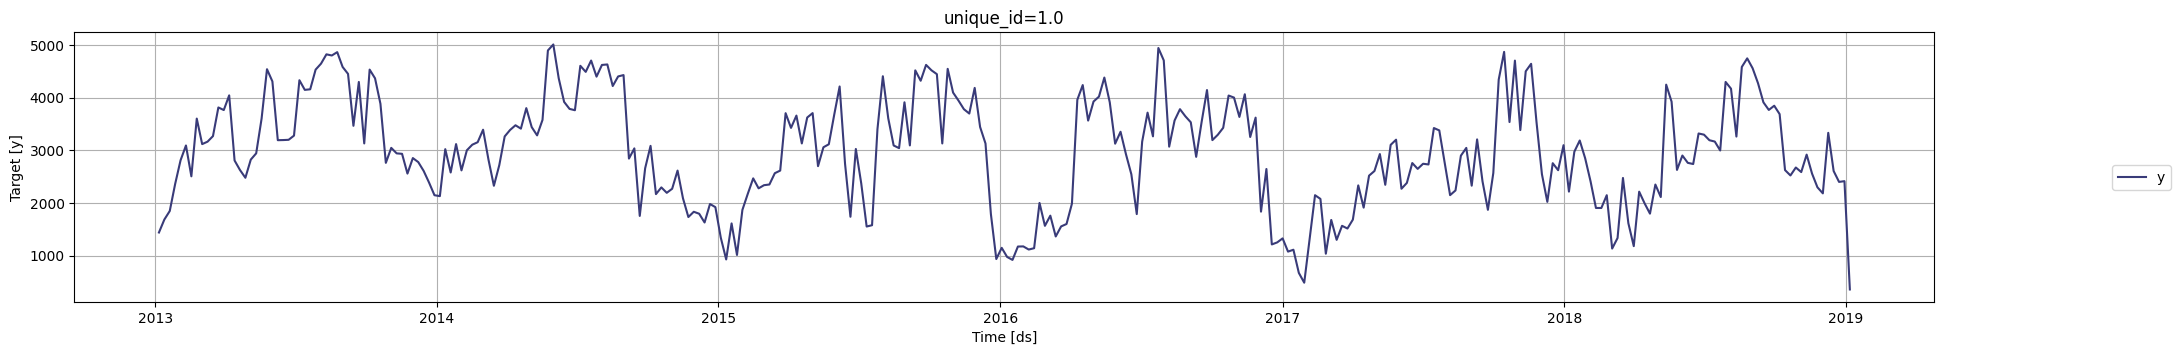

In [9]:
Y_df = df
StatsForecast.plot(Y_df)

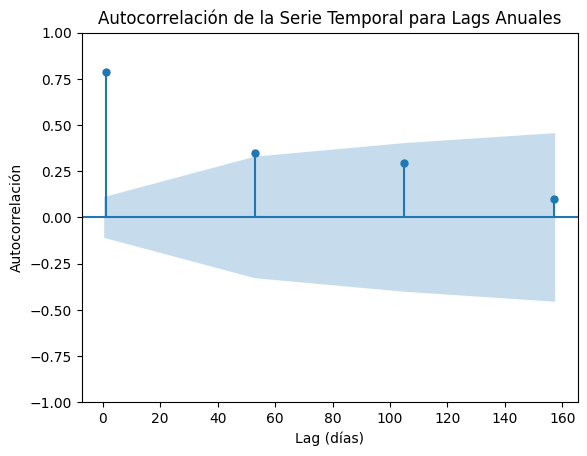

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Calcular la autocorrelación de la serie temporal para lags múltiplos del período estacional (365 días)
lags = range(1, 52*4, 52)  # Calcula la autocorrelación para lags
plot_acf(df.y, lags=lags)  # Especifica los lags a considerar
plt.xlabel('Lag (días)')
plt.ylabel('Autocorrelación')
plt.title('Autocorrelación de la Serie Temporal para Lags Anuales')
plt.show()

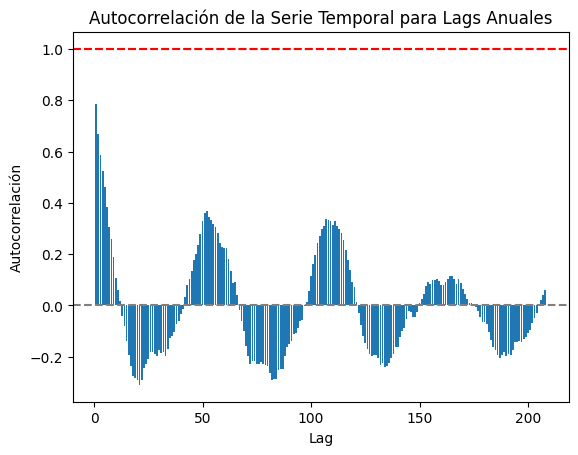

Lags significativos: []


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf


# Calcular la autocorrelación de la serie temporal para varios lags (por ejemplo, los primeros 365 días)
lag_max = 52*4  # Establece el número máximo de lags para considerar
lags = range(1, lag_max + 1)
autocorrelation, conf_int = acf(df.y, nlags=lag_max, alpha=0.05)

# Graficar la autocorrelación junto con los intervalos de confianza
plt.bar(lags, autocorrelation[1:])
plt.xlabel('Lag')
plt.ylabel('Autocorrelación')
plt.title('Autocorrelación de la Serie Temporal para Lags Anuales')
plt.axhline(y=0, color='gray', linestyle='--')  # Línea horizontal en y=0
plt.axhline(y=conf_int[0][0], color='red', linestyle='--')  # Límite inferior del intervalo de confianza
plt.axhline(y=conf_int[0][1], color='red', linestyle='--')  # Límite superior del intervalo de confianza
plt.show()

# Identificar los lags significativos (fuera del intervalo de confianza)
significant_lags = [lags[i] for i in range(len(lags)) if autocorrelation[i] > conf_int[i][1] or autocorrelation[i] < conf_int[i][0]]
print("Lags significativos:", significant_lags)

In [12]:
# Create a list of models and instantiation parameters
season_length = 52 # un año
models = [
    AutoARIMA(season_length = season_length),
    SeasonalNaive(season_length=season_length),
    AutoETS(season_length = season_length),
    AutoCES(season_length = season_length),
    AutoTheta(season_length = season_length),
    ADIDA(), 
    CrostonClassic(), 
    IMAPA(), 
    TSB(alpha_d = 0.2, alpha_p = 0.2),
]


In [13]:
# Instantiate StatsForecast class as sf
sf = StatsForecast( 
    models=models,
    freq='W',  # 'M' 'D'
    fallback_model = SeasonalNaive(season_length=season_length),
    n_jobs=-1,
)


In [14]:
forecasts_df = sf.forecast(df=Y_df, h=season_length, level=[90]) #
forecasts_df.head()

,unique_id,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,AutoETS,AutoETS-lo-90,...,ADIDA-hi-90,CrostonClassic,CrostonClassic-lo-90,CrostonClassic-hi-90,IMAPA,IMAPA-lo-90,IMAPA-hi-90,TSB,TSB-lo-90,TSB-hi-90
0,1.0,2019-01-13,973.919983,-57.698494,2005.538452,2974.834961,1141.686035,4807.983887,928.952942,-117.534622,...,4807.983887,2974.834961,1141.686035,4807.983887,2974.834961,1141.686035,4807.983887,2974.834961,1141.686035,4807.983887
1,1.0,2019-01-20,1215.749878,-59.172329,2490.672119,3187.708008,1354.559082,5020.856934,928.952942,-363.643005,...,5020.856934,3187.708008,1354.559082,5020.856934,3187.708008,1354.559082,5020.856934,3187.708008,1354.559082,5020.856934
2,1.0,2019-01-27,1167.316284,-251.743210,2586.375732,2851.308105,1018.159241,4684.457031,928.952942,-569.870728,...,4684.457031,2851.308105,1018.159241,4684.457031,2851.308105,1018.159241,4684.457031,2851.308105,1018.159241,4684.457031
3,1.0,2019-02-03,1107.269287,-439.672363,2654.210938,2412.448975,579.300110,4245.597656,928.952942,-750.969788,...,4245.597656,2412.448975,579.300110,4245.597656,2412.448975,579.300110,4245.597656,2412.448975,579.300110,4245.597656
4,1.0,2019-02-10,1039.574219,-622.812866,2701.961426,1905.782959,72.634087,3738.931885,928.952942,-914.361572,...,3738.931885,1905.782959,72.634087,3738.931885,1905.782959,72.634087,3738.931885,1905.782959,72.634087,3738.931885


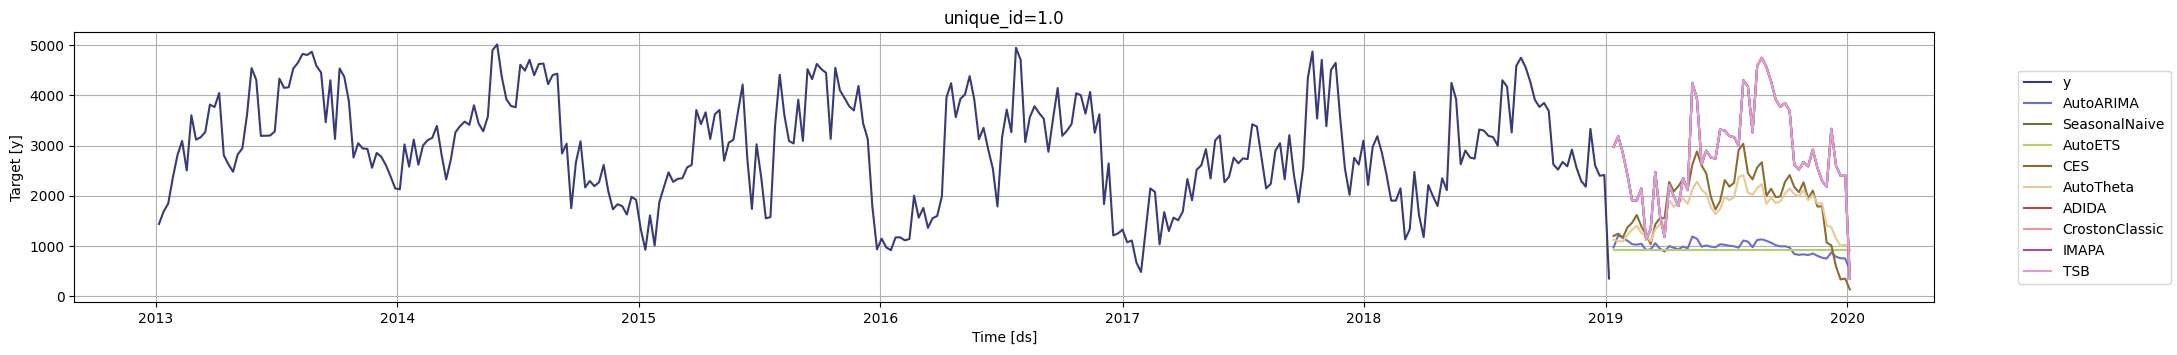

In [15]:
sf.plot(Y_df,forecasts_df)

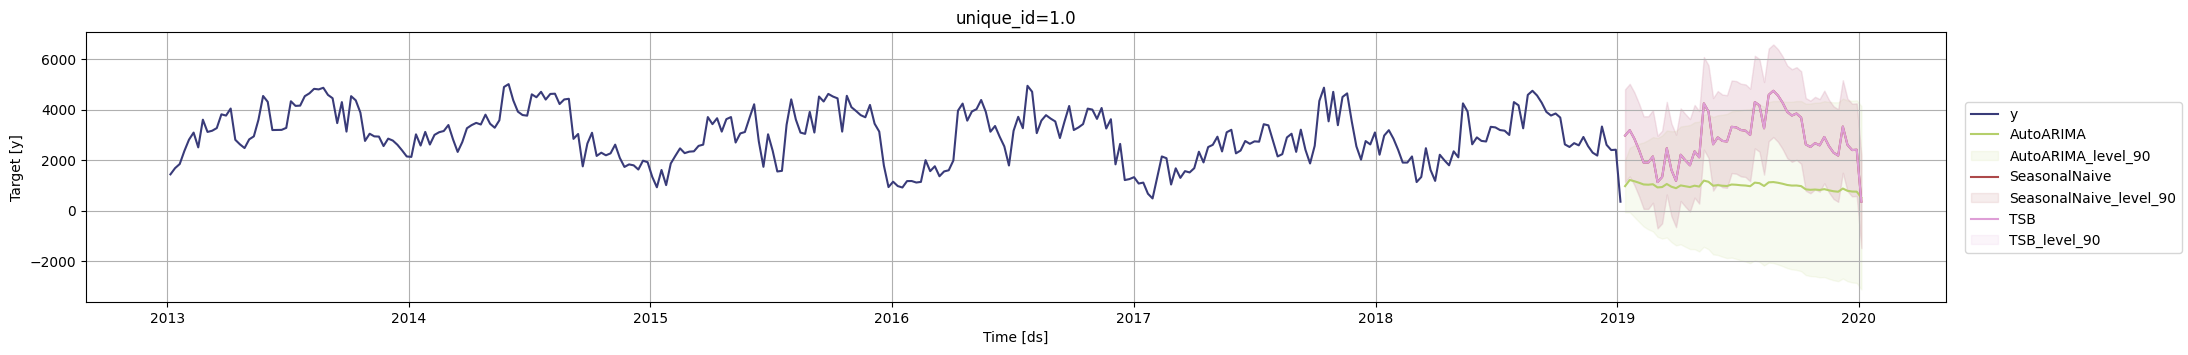

In [16]:
# Plot to unique_ids and some selected models
sf.plot(Y_df, forecasts_df, models=["AutoARIMA","SeasonalNaive","TSB"], unique_ids=[1.0], level=[90])


In [17]:
def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals


In [18]:
crossvalidation_df = sf.cross_validation(
    df=Y_df,
    h=season_length,
    step_size=season_length,
    n_windows=1
)


In [19]:
evaluation_df = evaluate_cross_validation(crossvalidation_df, mse)
evaluation_df.head()


,AutoARIMA,SeasonalNaive,AutoETS,CES,AutoTheta,ADIDA,CrostonClassic,IMAPA,TSB,best_model
unique_id,,,,,,,,,,
1.0,897600.3125,1523733.125,1073247.75,1024418.125,5297158.0,903812.25,935527.75,903812.25,896786.875,TSB
